# EMRI Waveforms in Time and Frequency Domain

In this tutorial, we demonstrate how to use the Fast EMRI Waveform package to produce waveforms in the time domain (TD) as described in [arXiv 2104.04582](https://arxiv.org/abs/2104.04582) and in the frequency domain (FD) as described in [arXiv 2307.12585](https://arxiv.org/abs/2307.12585). We explore the representation of EMRI waveforms in both domains using a reference source. We compare the TD and FD waveforms using mismatch and estimate the waveform generation speed. Additionally, we explore the impact of spin and eccentricity on the waveform signal-to-noise ratio. Finally, we demonstrate mass invariance and downsampling using the Frequency Domain.

Created by Lorenzo Speri

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from few.waveform import GenerateEMRIWaveform
from few.utils.constants import MTSUN_SI
from few.utils.utility import get_p_at_t, get_fundamental_frequencies
from few.utils.fdutils import GetFDWaveformFromFD, GetFDWaveformFromTD
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode.flux import KerrEccEqFlux

from scipy.interpolate import CubicSpline
from few import get_file_manager

# produce sensitivity function
traj_module = EMRIInspiral(func=KerrEccEqFlux)

# import ASD
data = np.loadtxt(get_file_manager().get_file("LPA.txt"), skiprows=1) 
data[:, 1] = data[:, 1] ** 2

# define PSD function
get_sensitivity = CubicSpline(*data.T)


# define inner product [eq 3 of https://www.nature.com/articles/s41550-022-01849-y]
def inner_product(x, y, psd):
    return 4 * np.real(np.sum(np.conj(x) * y / psd))



In [2]:
# Initialize waveform generators
# frequency domain generator
few_gen = GenerateEMRIWaveform(
    "FastKerrEccentricEquatorialFlux",
    sum_kwargs=dict(pad_output=True, output_type="fd", odd_len=True),
    return_list=True,
)

# time domain generator
td_gen = GenerateEMRIWaveform(
    "FastKerrEccentricEquatorialFlux",
    sum_kwargs=dict(pad_output=True, odd_len=True),
    return_list=True,
)

In [3]:
# define the injection parameters
m1 = 0.5e6  # central object mass (solar masses)
a = 0.9    # dimensionless spin parameter for the primary - will be ignored in Schwarzschild waveform
m2 = 10.0  # secondary object mass (solar masses)
p0 = 12.0  # initial dimensionless semi-latus rectum 
e0 = 0.1   # eccentricity

x0 = 1.0         # initial cos(inclination) - will be ignored in Schwarzschild waveform
qK = np.pi / 3   # polar spin angle
phiK = np.pi / 3 # azimuthal viewing angle
qS = np.pi / 3   # polar sky angle
phiS = np.pi / 3 # azimuthal viewing angle
dist = 1.0       # luminosity distance (Gpc)

# initial phases
Phi_phi0 = np.pi / 3
Phi_theta0 = 0.0
Phi_r0 = np.pi / 3

Tobs = 0.5  # observation time (years), if the inspiral is shorter, the it will be zero padded
dt = 5.0    # time interval (seconds)
eps = 1e-4  # relative threshold for mode inclusion: only modes making a relative contribution to
            # the total power above this threshold will be included in the waveform.

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
    "eps": eps,
}

# get the initial p0 required for an inspiral of length Tobs, given the fixed values of the other parameters
p0 = get_p_at_t(
    traj_module,
    Tobs * 0.999,
    [m1, m2, a, e0, 1.0],       # list of trajectory arguments, with p removed
    index_of_p=3,               # index where to insert the new p values in the above traj_args list when traj_module is called 
    index_of_a=2,               # index of a in the list of trajectory arguments above 
    index_of_e=4,               # etc...
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,                 # absolute tolerance for the brentq root finder
    rtol=8.881784197001252e-16, # relative tolerance for the brentq root finder
    bounds=None,
)
print("New p0: ", p0)

emri_injection_params = [
    m1,
    m2,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

New p0:  8.550316135028162


## Comparing Time and Frequency domain waveforms

In [4]:
# generate the TD signal, and time how long it takes
start = time.time()
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs) # Returns 2 arrays containing the plus and cross polarizations
end = time.time()
print("Time taken to generate the TD signal: ", end - start, "seconds")

# take the FFT of the plus polarization and shift it
fft_TD = np.fft.fftshift(np.fft.fft(data_channels_td[0])) * dt
freq = np.fft.fftshift(np.fft.fftfreq(len(data_channels_td[0]), dt))

# define the positive frequencies
positive_frequency_mask = freq >= 0.0

Time taken to generate the TD signal:  11.311679124832153 seconds


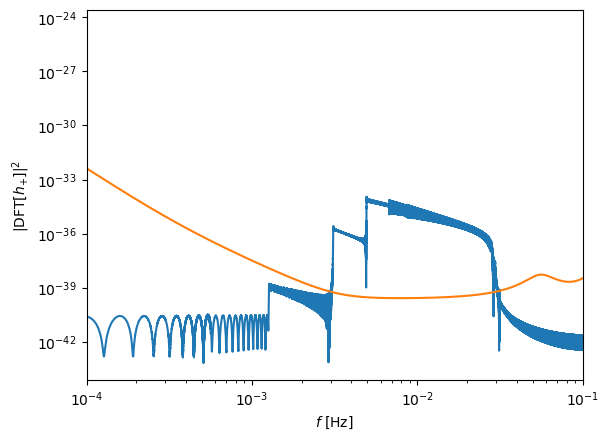

In [5]:
plt.figure()
plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask]) ** 2)
plt.loglog(
    freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask])
)
plt.ylabel(r"$| {\rm DFT} [h_{+}]|^2$")
plt.xlabel(r"$f$ [Hz]")
plt.xlim(1e-4, 1e-1)
plt.show()

In [6]:
# you can specify the frequencies or obtain them directly from the waveform
fd_kwargs = waveform_kwargs.copy()
fd_kwargs["f_arr"] = freq           # frequencies at which to output the waveform (optional)
fd_kwargs["mask_positive"] = True   # only output FD waveform at positive frequencies

# generate the FD signal directly, and time how long it takes
start = time.time()
hf = few_gen(*emri_injection_params, **fd_kwargs)
end = time.time()
print("Time taken to generate the FD signal: ", end - start, "seconds")

# to get the frequencies:
freq_fd = few_gen.waveform_generator.create_waveform.frequency

# calculate the mismatch between the FFT'd TD waveform and the direct FD waveform:
psd = get_sensitivity(freq[positive_frequency_mask]) / np.diff(freq)[0]
td_td = inner_product(
    fft_TD[positive_frequency_mask], fft_TD[positive_frequency_mask], psd
)
fd_fd = inner_product(hf[0], hf[0], psd)
Mism = np.abs(
    1
    - inner_product(fft_TD[positive_frequency_mask], hf[0], psd)
    / np.sqrt(td_td * fd_fd)
)
print("mismatch", Mism)

# SNR
print("TD SNR", np.sqrt(td_td))
print("FD SNR", np.sqrt(fd_fd))

Time taken to generate the FD signal:  2.2484607696533203 seconds
mismatch 0.0003755146491194461
TD SNR 59.74222866096887
FD SNR 59.74150135603114


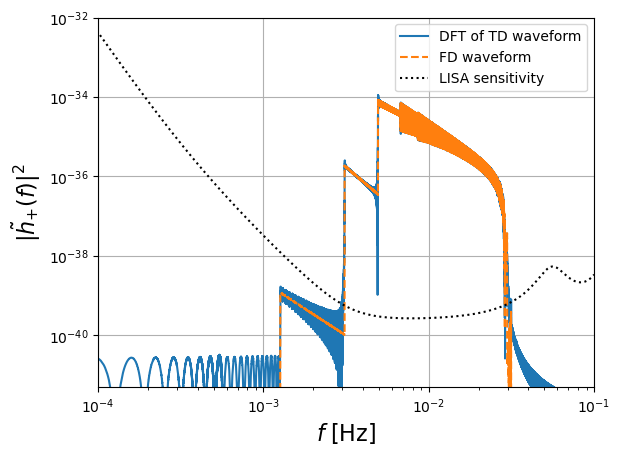

In [7]:
# FD plot
plt.figure()
plt.loglog(
    freq[positive_frequency_mask],
    np.abs(fft_TD[positive_frequency_mask]) ** 2,
    label="DFT of TD waveform",
)
plt.loglog(freq[positive_frequency_mask], np.abs(hf[0]) ** 2, "--", label="FD waveform")
plt.loglog(
    freq[positive_frequency_mask],
    get_sensitivity(freq[positive_frequency_mask]),
    "k:",
    label="LISA sensitivity",
)
plt.ylabel(r"$| \tilde{h}_{+} (f)|^2$", fontsize=16)
plt.grid()
plt.xlabel(r"$f$ [Hz]", fontsize=16)
plt.legend()
plt.ylim([0.5e-41, 1e-32])
plt.xlim([1e-4, 1e-1])
plt.show()
# plt.savefig('figures/FD_TD_frequency.pdf', bbox_inches='tight')

In the following example we transform the FD waveform to the time domain, and compare to the directly generated TD waveform:

In [8]:
# regenerate the FD waveform, outputting the negative frequencies too this time
fd_kwargs_temp = waveform_kwargs.copy()
fd_kwargs_temp["f_arr"] = freq
fd_kwargs_temp["mask_positive"] = False # do not mask the positive frequencies

hf_temp = few_gen(*emri_injection_params, **fd_kwargs_temp)

# check the consistency with the previous masked waveform
assert np.sum(hf_temp[0][positive_frequency_mask] - hf[0]) == 0.0

# transform FD waveform to TD
hf_to_ifft = np.append(
    hf_temp[0][positive_frequency_mask], hf_temp[0][~positive_frequency_mask]
)

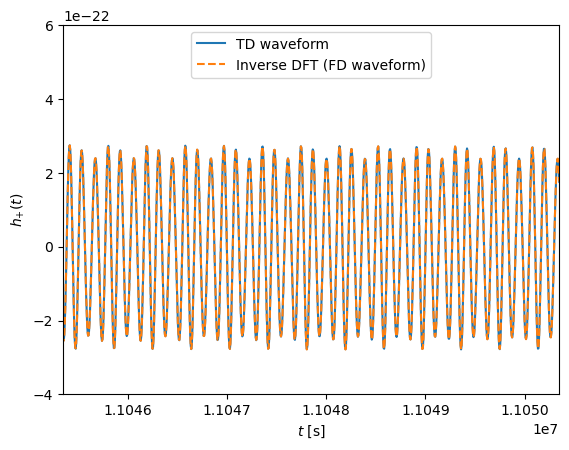

In [9]:
# Plot the waveforms in the time domain
plt.figure()
time_array = np.arange(0, len(data_channels_td[0])) * dt
plt.plot(time_array, data_channels_td[0].real, label="TD waveform")
ifft_fd = np.fft.ifft(hf_to_ifft / dt)
plt.plot(time_array, ifft_fd.real, "--", label="Inverse DFT (FD waveform)")
plt.ylabel(r"$h_{+}(t)$")
plt.xlabel(r"$t$ [s]")

t0 = time_array[-1] * 0.7
space_t = 10e3
plt.xlim([t0, t0 + space_t / 2])
plt.ylim([-4e-22, 6e-22])
plt.legend(loc="upper center")
plt.show()

In the following example we generate a downsampled FD waveform using the "f_arr" argument:

Time taken to generate the FD signal:  0.6659221649169922 seconds
freq_fd (1001,) h shape (1577908,)


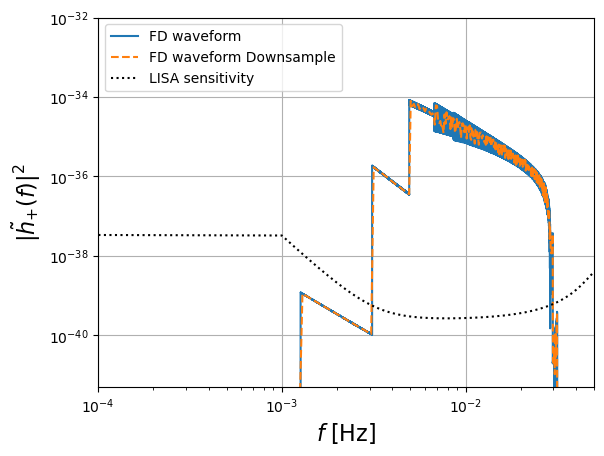

In [10]:
# construct downsampled frequency array
df = np.diff(freq)[0]
fmin, fmax = df, freq.max()
fmin, fmax = 1e-3, 5e-2
num_pts = 500
p_freq = np.append(0.0, np.linspace(fmin, fmax, num_pts))
freq_temp = np.hstack((-p_freq[::-1][:-1], p_freq))

# populate kwarg dictionary
fd_kwargs_ds = waveform_kwargs.copy()
fd_kwargs_ds["f_arr"] = freq_temp
fd_kwargs_ds["mask_positive"] = False

# get FD waveform with downsampled frequencies
hf_ds = few_gen(*emri_injection_params, **fd_kwargs_ds)
hf = few_gen(*emri_injection_params, **fd_kwargs)

# time the generation of the FD signal
start = time.time()
hf_ds = few_gen(*emri_injection_params, **fd_kwargs_ds)
end = time.time()
print("Time taken to generate the FD signal: ", end - start, "seconds")

# to get the frequencies:
freq_fd = few_gen.waveform_generator.create_waveform.frequency

# freq_temp = freq_temp[freq_temp>=0.0]
print("freq_fd", freq_fd.shape, "h shape", hf[0].shape)

# FD plot
plt.figure()
plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2, "-", label="FD waveform")
plt.loglog(freq_fd, np.abs(hf_ds[0])**2, "--", label="FD waveform Downsample")
plt.plot(freq_temp, get_sensitivity(freq_temp), "k:", label="LISA sensitivity")
plt.ylabel(r"$| \tilde{h}_{+} (f)|^2$", fontsize=16)
plt.grid()
plt.xlabel(r"$f$ [Hz]", fontsize=16)
plt.legend(loc="upper left")
plt.ylim([0.5e-41, 1e-32])
plt.xlim([1e-4, 5e-2])
plt.show()
# plt.savefig('figures/FD_TD_frequency.pdf', bbox_inches='tight')

## FD utilities and windowing

The generation of FD waveforms using a given choice of waveform generator (either TD or FD) can be simplified using the `GetFDWaveformFromTD` and `GetFDWaveformFromFD` classes from the utilities module. These classes allow one to easily specify a choice of window function to use, as illustrated by the following example:

In [11]:
from scipy.signal.windows import tukey

fd_kwargs_nomask = fd_kwargs.copy()
del fd_kwargs_nomask["mask_positive"]

# no windowing
window = np.ones(len(data_channels_td[0]))  
fft_td_gen = GetFDWaveformFromTD(td_gen, positive_frequency_mask, dt, window=window) # generate an FD waveform by FFT'ing a TD waveform
fd_gen = GetFDWaveformFromFD(few_gen, positive_frequency_mask, dt, window=window) # generate an FD waveform directly using an FD generator

np.all(fd_gen(*emri_injection_params, **fd_kwargs_nomask)[0] == hf[0])

hf = fd_gen(*emri_injection_params, **fd_kwargs_nomask)
fft_TD = fft_td_gen(*emri_injection_params, **fd_kwargs_nomask)

# calculate SNRs and mismatch
psd = get_sensitivity(freq[positive_frequency_mask]) / np.diff(freq)[0]
td_td = inner_product(fft_TD[0], fft_TD[0], psd)
fd_fd = inner_product(hf[0], hf[0], psd)
Mism = np.abs(1 - inner_product(fft_TD[0], hf[0], psd) / np.sqrt(td_td * fd_fd))

print(" ***** No window ***** ")
print("mismatch", Mism)
print("TD SNR", np.sqrt(td_td))
print("FD SNR", np.sqrt(fd_fd))


# add windowing
window = np.asarray(tukey(len(data_channels_td[0]), 0.01))  
fft_td_gen = GetFDWaveformFromTD(td_gen, positive_frequency_mask, dt, window=window)
fd_gen = GetFDWaveformFromFD(few_gen, positive_frequency_mask, dt, window=window)

hf_win = fd_gen(*emri_injection_params, **fd_kwargs_nomask)
fft_TD_win = fft_td_gen(*emri_injection_params, **fd_kwargs_nomask)

# calculate SNRs and mismatch
psd = get_sensitivity(freq[positive_frequency_mask]) / np.diff(freq)[0]
td_td = inner_product(fft_TD_win[0], fft_TD_win[0], psd)
fd_fd = inner_product(hf_win[0], hf_win[0], psd)
Mism = np.abs(1 - inner_product(fft_TD_win[0], hf_win[0], psd) / np.sqrt(td_td * fd_fd))

print("\n\n ***** With window ***** ")
print("mismatch", Mism)
print("TD SNR", np.sqrt(td_td))
print("FD SNR", np.sqrt(fd_fd))

 ***** No window ***** 
mismatch 0.00037551464911966814
TD SNR 59.74222866096887
FD SNR 59.741501356031165


 ***** With window ***** 
mismatch 0.00014233146844810918
TD SNR 59.53730937395696
FD SNR 59.5514051713823


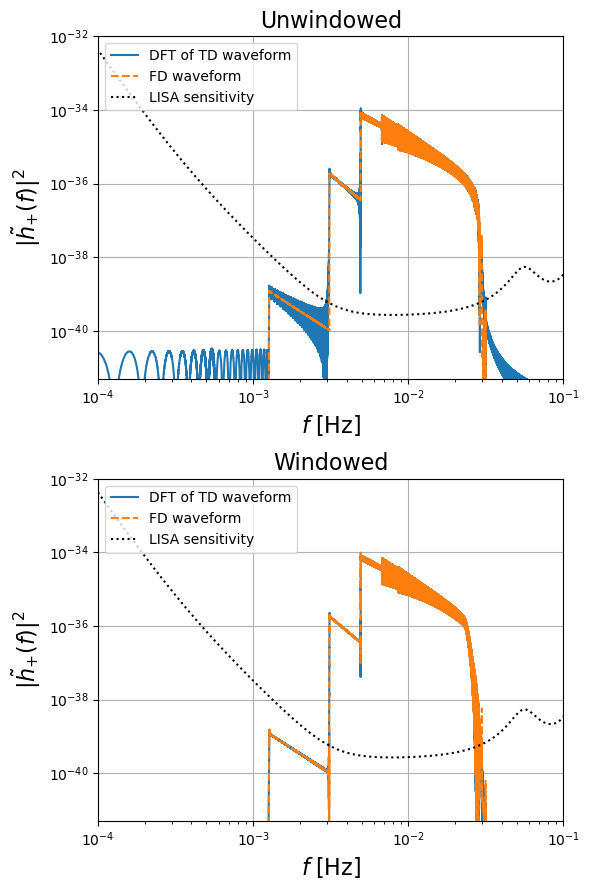

In [12]:
# FD plot
plt.figure(figsize=(6, 9))
plt.subplot(2,1,1)
plt.title("Unwindowed", fontsize=16)
plt.loglog(
    freq[positive_frequency_mask], np.abs(fft_TD[0]) ** 2, label="DFT of TD waveform"
)
plt.loglog(freq[positive_frequency_mask], np.abs(hf[0]) ** 2, "--", label="FD waveform")
plt.loglog(
    freq[positive_frequency_mask],
    get_sensitivity(freq[positive_frequency_mask]),
    "k:",
    label="LISA sensitivity",
)
plt.ylabel(r"$| \tilde{h}_{+}(f)|^2$", fontsize=16)
plt.xlabel(r"$f$ [Hz]", fontsize=16)
plt.legend(loc='upper left')
plt.grid()
plt.ylim([0.5e-41, 1e-32])
plt.xlim([1e-4, 1e-1])
#plt.show()
# plt.savefig('figures/FD_TD_frequency_windowed.pdf', bbox_inches='tight')

plt.subplot(2,1,2)
plt.title("Windowed", fontsize=16)
plt.loglog(
    freq[positive_frequency_mask], np.abs(fft_TD_win[0]) ** 2, label="DFT of TD waveform"
)
plt.loglog(freq[positive_frequency_mask], np.abs(hf_win[0]) ** 2, "--", label="FD waveform")
plt.loglog(
    freq[positive_frequency_mask],
    get_sensitivity(freq[positive_frequency_mask]),
    "k:",
    label="LISA sensitivity",
)
plt.ylabel(r"$| \tilde{h}_{+}(f)|^2$", fontsize=16)
plt.xlabel(r"$f$ [Hz]", fontsize=16)
plt.legend(loc='upper left')
plt.grid()
plt.ylim([0.5e-41, 1e-32])
plt.xlim([1e-4, 1e-1])
plt.gcf().tight_layout()


# Signal to noise ratio as a function of eccentricity and spin

In [13]:
def calculate_snr_mismatch(
    mode,
    emri_injection_params,
    waveform_kwargs,
    fd_kwargs,
    freq,
    positive_frequency_mask,
    dt,
):
    # Update fd_kwargs and td_kwargs with the current mode
    fd_kwargs = fd_kwargs.copy()
    fd_kwargs.pop("eps")
    fd_kwargs["mode_selection"] = [mode]
    hf_mode = few_gen(*emri_injection_params, **fd_kwargs)

    td_kwargs2 = waveform_kwargs.copy()
    td_kwargs2.pop("eps")
    td_kwargs2["mode_selection"] = [mode]
    data_channels_td_mode = td_gen(*emri_injection_params, **td_kwargs2)

    # Take the FFT of the plus polarization and shift it
    fft_TD_mode = np.fft.fftshift(np.fft.fft(data_channels_td_mode[0])) * dt

    # Calculate PSD
    psd = get_sensitivity(freq[positive_frequency_mask]) / np.diff(freq)[0]

    # Calculate inner products
    td_td = inner_product(
        fft_TD_mode[positive_frequency_mask], fft_TD_mode[positive_frequency_mask], psd
    )
    fd_fd = inner_product(hf_mode[0], hf_mode[0], psd)
    Mism = np.abs(
        1
        - inner_product(fft_TD_mode[positive_frequency_mask], hf_mode[0], psd)
        / np.sqrt(td_td * fd_fd)
    )

    # calculated frequency
    OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(
        emri_injection_params[2],
        emri_injection_params[3],
        emri_injection_params[4],
        emri_injection_params[5],
    )
    harmonic_frequency = (OmegaPhi * mode[1] + OmegaR * mode[2]) / (
        emri_injection_params[0] * MTSUN_SI * 2 * np.pi
    )
    return np.sqrt(td_td), Mism, harmonic_frequency


# Initialize data storage
data_out = []

# mode vector
eccentricity_vector = [0.1, 0.3, 0.7]
max_n_vector = [10, 18, 26]
spin_vector = [0.0, 0.9]

for a in spin_vector:
    for l_set, m_set in zip([2], [2]):
        temp = emri_injection_params.copy()
        for e_temp, max_n in zip(eccentricity_vector, max_n_vector):
            modes = [(l_set, m_set, ii) for ii in range(-3, max_n)]
            p_temp = get_p_at_t(
                traj_module,
                Tobs * 0.99,
                [m1, m2, a, e_temp, 1.0],
                index_of_p=3,
                index_of_a=2,
                index_of_e=4,
                index_of_x=5,
                traj_kwargs={},
                xtol=2e-12,
                rtol=8.881784197001252e-16,
                bounds=None,
            )
            temp[3] = p_temp
            temp[4] = e_temp
            temp[2] = a
            out = np.asarray(
                [
                    calculate_snr_mismatch(
                        mode,
                        temp,
                        waveform_kwargs,
                        fd_kwargs,
                        freq,
                        positive_frequency_mask,
                        dt,
                    )
                    for mode in modes
                ]
            )
            snr, Mism, harmonic_frequency = out.T
            data_out.append((harmonic_frequency, snr, l_set, m_set, e_temp, a))

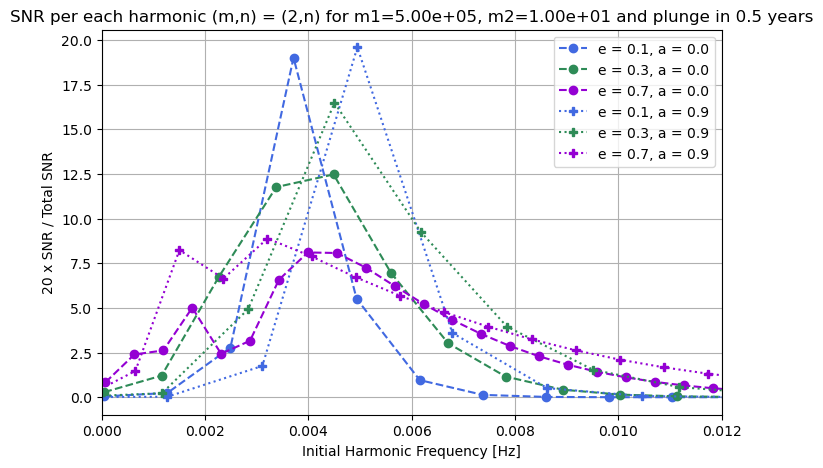

In [14]:
# Plot the data
colors = {0.1: "royalblue", 0.3: "seagreen", 0.5: "crimson", 0.7: "darkviolet"}

plt.figure(figsize=(8, 5))
for harmonic_frequency, snr, l_set, m_set, e_temp, a in data_out:
    color = colors[e_temp]
    if a == 0.9:
        plt.plot(
            harmonic_frequency,
            20.0 * snr / np.sum(snr**2) ** 0.5,
            ":P",
            label=f"e = {e_temp}, a = {a}",
            color=color,
        )
        # plt.text(harmonic_frequency[-1], 20.0 * snr[-1]/np.sum(snr**2)**0.5, f"({l_set},{m_set})", fontsize=8)
    if a == 0.0:
        plt.plot(
            harmonic_frequency,
            20.0 * snr / np.sum(snr**2) ** 0.5,
            "--o",
            label=f"e = {e_temp}, a = {a}",
            color=color,
        )
        # for ii in range(len(harmonic_frequency)):
        #     plt.text(harmonic_frequency[ii], 20.0 * snr[ii]/np.sum(snr**2)**0.5, f"n={ii-3}", fontsize=8)

plt.xlabel("Initial Harmonic Frequency [Hz]")
plt.ylabel("20 x SNR / Total SNR")
plt.title(
    f"SNR per each harmonic (m,n) = ({2},n) for m1={m1:.2e}, m2={m2:.2e} and plunge in {Tobs} years"
)
plt.xlim(0, 0.012)
plt.grid()
plt.legend()
plt.show()

In [15]:
# Initialize data storage
data_out = []

# mode vector
a = 0.0
Tobs = 0.1  # observation time, if the inspiral is shorter, the it will be zero padded
eccentricity_vector = [0.1, 0.5]
max_n_vector = [10, 26]
eta_vector = [1e-4, 1e-6]  # mass ratio values

for eta in eta_vector:
    for e_temp, max_n in zip(eccentricity_vector, max_n_vector):
        temp = emri_injection_params.copy()
        m2 = eta * m1
        p_temp = get_p_at_t(
            traj_module,
            Tobs * 0.99,
            [m1, m2, a, e_temp, 1.0],
            index_of_p=3,
            index_of_a=2,
            index_of_e=4,
            index_of_x=5,
            traj_kwargs={},
            xtol=2e-6,
            rtol=8.881784197001252e-6,
        )
        temp[3] = p_temp
        temp[4] = e_temp
        temp[1] = m2
        for l_set, m_set in zip([2], [2]):
            modes = [(l_set, m_set, ii) for ii in range(-3, max_n)]
            out = np.asarray(
                [
                    calculate_snr_mismatch(
                        mode,
                        temp,
                        waveform_kwargs,
                        fd_kwargs,
                        freq,
                        positive_frequency_mask,
                        dt,
                    )
                    for mode in modes
                ]
            )
            snr, Mism, harmonic_frequency = out.T
            data_out.append((harmonic_frequency, snr, l_set, m_set, e_temp, eta))

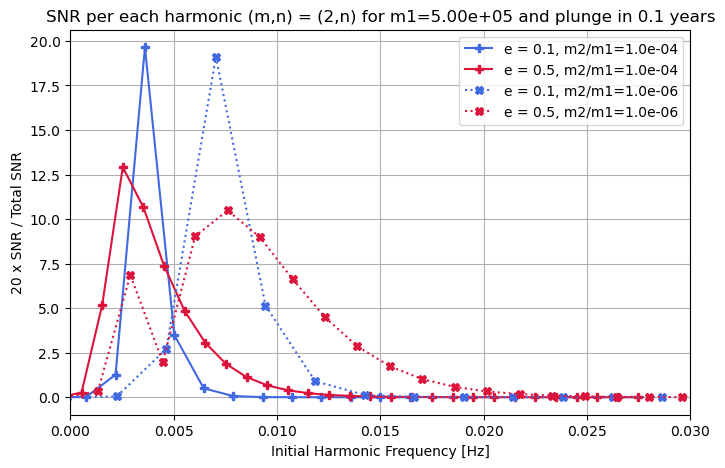

In [16]:
# Plot the data
colors = {0.1: "royalblue", 0.3: "seagreen", 0.5: "crimson", 0.7: "darkviolet"}

plt.figure(figsize=(8, 5))
for harmonic_frequency, snr, l_set, m_set, e_temp, eta_temp in data_out:
    color = colors[e_temp]
    if eta_temp == 1e-4:
        plt.plot(
            harmonic_frequency,
            20.0 * snr / np.sum(snr**2) ** 0.5,
            "-P",
            label=f"e = {e_temp}, m2/m1={eta_temp:.1e}",
            color=color,
        )
    if eta_temp == 1e-6:
        plt.plot(
            harmonic_frequency,
            20.0 * snr / np.sum(snr**2) ** 0.5,
            ":X",
            label=f"e = {e_temp}, m2/m1={eta_temp:.1e}",
            color=color,
        )

plt.xlabel("Initial Harmonic Frequency [Hz]")
plt.ylabel("20 x SNR / Total SNR")
plt.title(
    f"SNR per each harmonic (m,n) = ({2},n) for m1={m1:.2e} and plunge in {Tobs} years"
)
plt.xlim(0, 0.03)
plt.grid()
plt.legend()
plt.show()

## Speed test as a function of the parameter space

In [17]:
# create a function that times the FD and TD waveform generation for different input parameters


def time_waveform_generation(fd_waveform_func, td_waveform_func, input_params, kwargs):
    """
    Times the FD and TD waveform generation for different input parameters.

    Parameters:
    fd_waveform_func (function): Function to generate FD waveform.
    td_waveform_func (function): Function to generate TD waveform.
    input_params (list): List of dictionaries containing input parameters for the waveform functions.

    Returns:
    list: List of dictionaries containing input parameters and their corresponding FD and TD generation times.
    """
    results = []

    for params in input_params:
        # Time FD waveform generation
        start_time = time.time()
        fd_waveform_func(*params, **kwargs)
        fd_time = time.time() - start_time

        # Time TD waveform generation
        start_time = time.time()
        td_waveform_func(*params, **kwargs)
        td_time = time.time() - start_time

        # Store the results
        result = {"input_params": params, "fd_time": fd_time, "td_time": td_time}
        print(result)
        results.append(result)

    return results


timing_results = []
vec_par = []
Tobs = 2.0
# create a list of input parameters for m1, m2, a, p0, e0, x0
for mass in [1e5, 1e6, 1e7]:
    for el in np.linspace(0.1, 0.6, num=3):
        temp = emri_injection_params.copy()
        temp[0] = mass
        temp[4] = el
        temp[3] = get_p_at_t(
            traj_module,
            Tobs * 0.99,
            [temp[0], temp[1], temp[2], temp[4], 1.0],
            index_of_p=3,
            index_of_a=2,
            index_of_e=4,
            index_of_x=5,
            traj_kwargs={},
            xtol=2e-6,
            rtol=8.881784197001252e-6,
        )
        vec_par.append(temp.copy())

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
    "eps": 1e-2,
}
timing_results = time_waveform_generation(few_gen, td_gen, vec_par, waveform_kwargs)

print(timing_results)

{'input_params': [100000.0, 10.0, 0.9, 27.805649045924806, 0.1, 1.0, 1.0, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 0.0, 1.0471975511965976], 'fd_time': 6.880403518676758, 'td_time': 2.39565110206604}
{'input_params': [100000.0, 10.0, 0.9, 27.516124458041023, 0.35, 1.0, 1.0, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 0.0, 1.0471975511965976], 'fd_time': 10.915303230285645, 'td_time': 3.7199201583862305}
{'input_params': [100000.0, 10.0, 0.9, 26.568579826986564, 0.6, 1.0, 1.0, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 0.0, 1.0471975511965976], 'fd_time': 40.31546115875244, 'td_time': 6.868464708328247}
{'input_params': [1000000.0, 10.0, 0.9, 8.530434740112957, 0.1, 1.0, 1.0, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 1.0471975511965976, 0.0, 1.0471975511965976], 'fd_time': 2.93384

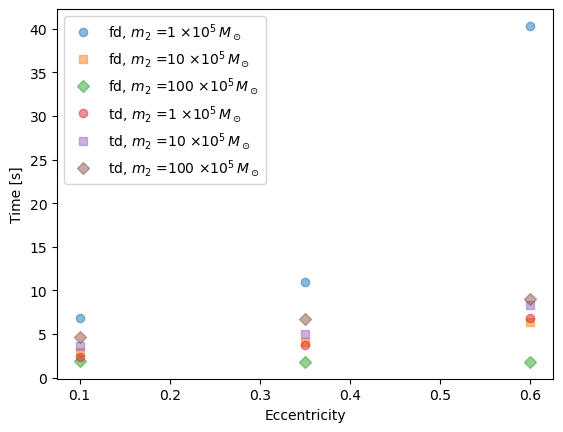

In [24]:
markers = ["o", "s", "D", "^", "v", "<", ">", "p", "*", "h", "H", "+", "x", "d", "|", "_"]
masses = sorted(set([el["input_params"][0] for el in timing_results]))

for lab in ["fd_time", "td_time"]:
    for i, mass in enumerate(masses):
        timing = [el[lab] for el in timing_results if el["input_params"][0] == mass]
        ecc = [el["input_params"][4] for el in timing_results if el["input_params"][0] == mass]
        plt.plot(ecc, timing, markers[i % len(markers)], label=fr"{lab[:2]}, $m_2$ ={ int(mass/1e5)} $\times 10^5 \, M_\odot$", alpha=0.5)
plt.xlabel("Eccentricity")
plt.ylabel("Time [s]")
plt.legend()
plt.show()

## Mass invariance
If we fix the mass ratio of an EMRI system the frequency domain waveform is invariant under a total mass change as long as we consider dimensionless frequencies. We show this here as a check of our frequency domain implementation.

In [19]:
list_h = []
list_f = []
T = 4.0
dt = 10.0
# array of total masses
Mvec = 10 ** np.linspace(5.0, 6.5, num=3)

for m1 in Mvec:
    # fix mass ratio
    m2 = 5e-5 * m1

    # rescale time
    Tnew = T * (m1 / 1e6)

    # generate wave
    list_h.append(
        few_gen(
            m1,
            m2,
            a,
            p0,
            e0,
            x0,
            dist,
            qS,
            phiS,
            qK,
            phiK,
            Phi_phi0,
            Phi_theta0,
            Phi_r0,
            T=10.0,
            dt=dt,
            mode_selection=[(2, 2, 0)],
            mask_positive=True,
        )
    )

    # dimensionless frequency
    list_f.append(few_gen.waveform_generator.create_waveform.frequency * m1 * MTSUN_SI)

/home/whittacl/miniforge3/envs/few_hackathon_tues/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


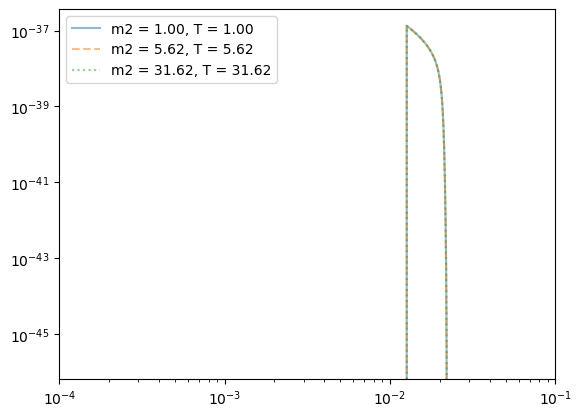

In [20]:
ls_arr = ['-', '--', ':']
plt.figure()
for ii in range(len(Mvec)):
    Tnew = 10.0 * Mvec[ii] / 1e6
    tmp_m2 = 1e-5 * Mvec[ii]

    ff = list_f[ii]
    ff = ff[ff >= 0.0]
    h2 = np.abs(list_h[ii][0] / (tmp_m2 * Tnew)) ** 2
    plt.loglog(ff, h2, linestyle=ls_arr[ii], label=f"m2 = {tmp_m2:.2f}, T = {Tnew:.2f}", alpha=0.5)

plt.xlim([1e-4, 1e-1])
plt.legend()
plt.show()

## Downsampled FD Waveforms
One of the main advantages of the frequency domain formulation is that we can downsample the frequencies to reduce the computational cost of the waveform. This is illustrated in the following cells where we perform different levels of downsampling.

In [21]:
m1, m2, p0, e0 = (
    3670041.7362535275,
    292.0583167470244,
    13.709101864726545,
    0.5794130830706371,
)  # 1e6, 10.0, 13.709101864726545, 0.5794130830706371 #

x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi / 3  # polar spin angle
phiK = np.pi / 3  # azimuthal viewing angle
qS = np.pi / 3  # polar sky angle
phiS = np.pi / 3  # azimuthal viewing angle
dist = 1.0  # distance
# initial phases
Phi_phi0 = np.pi / 3
Phi_theta0 = 0.0
Phi_r0 = np.pi / 3

Tobs = 4.0  # observation time, if the inspiral is shorter, the it will be zero padded
dt = 10.0  # time interval
eps = 1e-2  # mode content percentage
mode_selection = [(2, 2, 0)]

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
    # you can uncomment the following ling if you want to show a mode
    #     "mode_selection" : mode_selection,
    #     "include_minus_m": True
    "eps": eps,
}

# get the initial p0
p0 = get_p_at_t(
    traj_module,
    Tobs * 0.99,
    [m1, m2, 0.0, e0, 1.0],
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)


emri_injection_params = [
    m1,
    m2,
    a,
    p0,
    e0,
    x0,
    dist,
    qS,
    phiS,
    qK,
    phiK,
    Phi_phi0,
    Phi_theta0,
    Phi_r0,
]

max frequency 0.002815809639046519
max frequency 0.002815809639046519


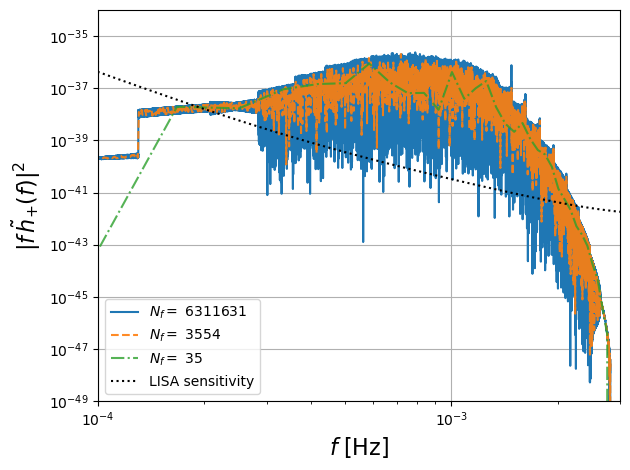

In [22]:
# FD plot
plt.figure()

alpha = [1.0, 0.9, 0.8, 0.2]
linest = ["-", "--", "-.", ":"]

for upp, aa, ls in zip([1, 100, 10000], alpha, linest):
    # you can specify the frequencies or obtain them directly from the waveform
    fd_kwargs = waveform_kwargs.copy()
    fd_kwargs["mask_positive"] = True
    # get FD waveform
    hf = few_gen(*emri_injection_params, **fd_kwargs)
    freq_fd = few_gen.waveform_generator.create_waveform.frequency
    positive_frequency_mask = freq_fd >= 0.0
    mask_non_zero = hf[0] != complex(0.0)
    end_f = few_gen.waveform_generator.create_waveform.frequency[
        positive_frequency_mask
    ][mask_non_zero].max()

    if upp != 1:
        num = int(len(freq_fd[positive_frequency_mask][mask_non_zero]) / upp)
        p_freq = np.linspace(0.0, end_f * 1.01, num=num)
        print("max frequency", end_f)
        newfreq = np.hstack((-p_freq[::-1][:-1], p_freq))

        # you can specify the frequencies or obtain them directly from the waveform
        fd_kwargs = waveform_kwargs.copy()
        fd_kwargs["f_arr"] = newfreq
        fd_kwargs["mask_positive"] = True

        # get FD waveform
        hf = few_gen(*emri_injection_params, **fd_kwargs)
        # to get the frequencies:
        freq_fd = few_gen.waveform_generator.create_waveform.frequency
        positive_frequency_mask = freq_fd >= 0.0

    Nf = len(freq_fd[positive_frequency_mask])
    plt.loglog(
        freq_fd[positive_frequency_mask],
        freq_fd[positive_frequency_mask] ** 2 * np.abs(hf[0]) ** 2,
        ls,
        label=f"$N_f = $ {Nf}",
        alpha=aa,
    )


ff = 10 ** np.linspace(-5, -1, num=100)
plt.loglog(ff, ff * get_sensitivity(ff), "k:", label="LISA sensitivity")

plt.ylabel(r"$|f\, \tilde{h}_{+}(f)|^2$", fontsize=16)
plt.xlabel(r"$f$ [Hz]", fontsize=16)
plt.legend(loc="lower left")
plt.xlim(1e-4, 3e-3)
plt.grid()
plt.ylim([1e-49, 1e-34])
plt.tight_layout()
plt.show()

# plt.savefig('figures/spectrum_downsampled.pdf')